In [2]:
library(tidyverse)
library(stringr)
library(cluster)
library(factoextra)

In [6]:
ggplot2::theme_set(ggplot2::theme_light())

In [3]:
mnist <- dslabs::read_mnist()
names(mnist)

[1] "train" "test"

In [4]:
url <- "https://koalaverse.github.io/homlr/data/my_basket.csv"
my_basket <- readr::read_csv(url)

Rows: 2000 Columns: 42
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (42): 7up, lasagna, pepsi, yop, red.wine, cheese, bbq, bulmers, mayonnai...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


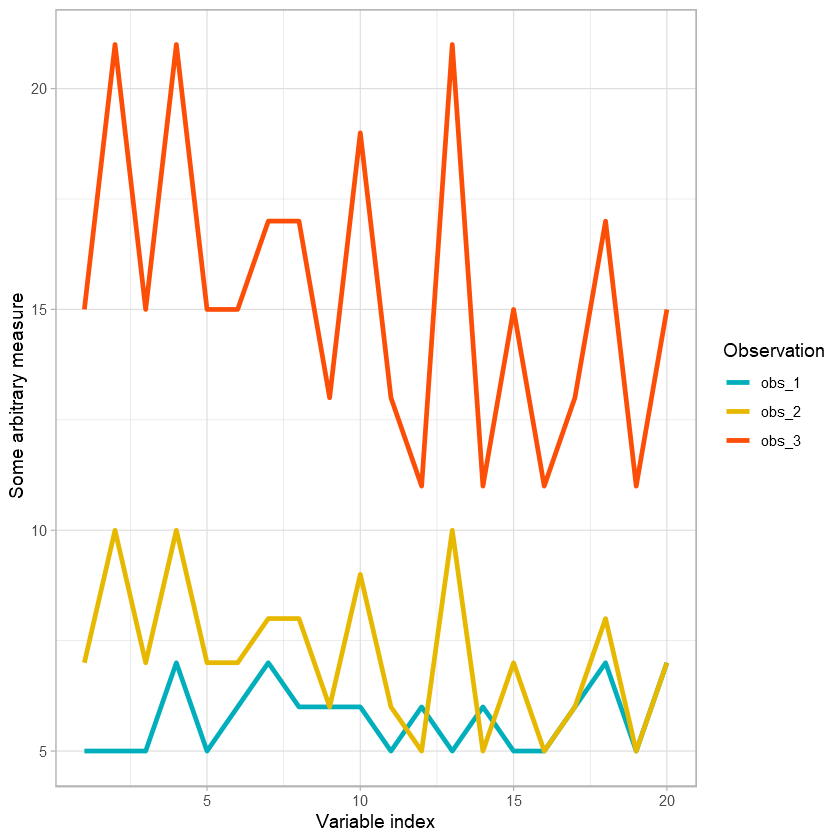

In [9]:
corr_ex <- tibble(
  v = 1:20,
  obs_1 = sample(5:7, 20, replace = TRUE),
  obs_2 = sample(4:10, 20, replace = TRUE)
) %>%
  mutate(obs_3 = obs_2 * 2 + sample(0:1, 1))

corr_ex %>%
  gather(Observation, value, obs_1:obs_3) %>%
  ggplot(aes(v, value, color = Observation)) +
  geom_line(size = 1) +
  scale_colour_manual(values = c("#00AFBB", "#E7B800", "#FC4E07")) +
  scale_x_continuous("Variable index") +
  scale_y_continuous("Some arbitrary measure")

### 거리측정
1. 유클리드 : 이상값에 매우 민감, 변수가 정규분포에 근사할때, 합리적, 변수가 정규성에서 크게 벗어나거나, 기존 이상갑에 대해 robust하길 원한다면 맨하탄, 민코우스키, Gower거리 사용
2. Gower 거리 : 범주형 및 순서형 특징을 포함시
3. 코사인거리 : 텍스트 마이닝 
4. **상관기반 거리 : 관측값의 크기 차이는 크지만, 형태가 비슷한 un-scaled데이터일 경우, 비상관기반 거리측정보다 두 관찰간의 상관관계를 더 잘 포착**

### 군집정의
- 군집 내 전체 변동이 치소화
- **관측치와, 군집의 중심점(C)사이의 유클리드 거리의 합을 군집 내 총 변동으로 정의**



- **존재하는 모든 군집들의, 군집내 변동을 최소화** : minimize (SS_within)

- K-평균의 기본가정은, 군집 중심점에 가깝도록 하는 것
- 복잡한 기하학적 그룹을 포착하는데 비효율적
- Spectral clustering 사용 필요

### K-평균 알고리즘
1. 군집의 수를 설정하는 것
2. 초기 중심점으로 사용할 관측치를 무작위로 선정
3. 선택한 거리 측정법을 기반으로, 중심점에 가장 가까운 관측치를 할당
4. 군집에 있는 모든 관측값의 새 평균값을 계산하여, 중심을 업데이트
5. 클러스터 할당 변경이 중지되거나(일부 임계값 초과) 최대 반복 횟수에 도달할 때까지 3-4단계를 반복하여, SS_within를 최소화  (10-20번의 반복)

### ```kmeans()```
- ```centers``` : 군집의 수
- ```nstart``` : 반복횟수

#### ```withinss``` : 군집 내 총변동
#### ```tot.withinss``` : 군집 내 변동 총제곱합
#### ```size``` : : 각 군집의 크기
#### ```iter``` : 반복횟수
#### ```centers``` : 각 군집의 중심

In [60]:
create_data <- function(sd) {
  data_frame(
    x1 = c(rnorm(100, sd = sd), rnorm(100, sd = sd) + 3),
    x2 = c(rnorm(100, sd = sd), rnorm(100, sd = sd) - 2)
  ) %>%
    mutate(`W(Ck)` = case_when(
      sd == 0.5  ~ "Best",
      sd == 0.75 ~ "Better",
      sd == 1   ~ "Good"
    ))
}
df <- map(c(0.5, 0.75, 1), create_data)
dim(df[[1]]) ; dim(df[[2]]) ; dim(df[[3]]) ; df[[1]] %>% head

[1] 200   3

[1] 200   3

[1] 200   3

x1,x2,W(Ck)
<dbl>,<dbl>,<chr>
0.3693091,-0.304273501,Best
-0.2956320,0.396914353,Best
-0.5390568,-0.008802561,Best
1.0867220,0.029340773,Best
-0.6192078,0.570701772,Best
-0.1280196,0.087778921,Best


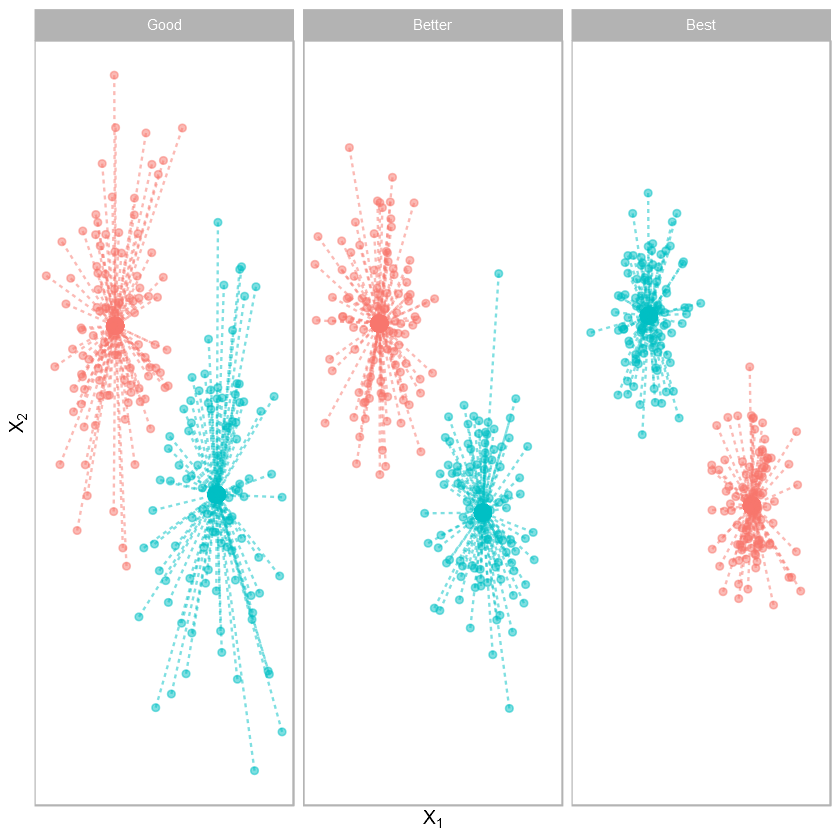

In [73]:
k2 <- map(df, ~ kmeans(.x[, 1:2], 2, nstart = 20))

df <- map2(df, k2, ~ mutate(.x, cluster = .y$cluster)) %>%
  map2_dfr(k2, ~ inner_join(.x, .y$centers %>% 
                          as.data.frame() %>% 
                          mutate(cluster = row_number()), by = "cluster")
       ) %>%
  rename(x1 = x1.x, x2 = x2.x, x_center = x1.y, y_center = x2.y) %>%
  mutate(`W(Ck)` = factor(`W(Ck)`, levels = c("Good", "Better", "Best")))

df %>%
  ggplot(aes(colour = factor(cluster))) +
  facet_wrap(~ `W(Ck)`) +
  geom_segment(aes(x = x1, xend = x_center, y = x2, yend = y_center), lty = "dashed", alpha = .5) +
  geom_point(aes(x_center, y_center), size = 4) +
  geom_point(aes(x1, x2), show.legend = FALSE, alpha = .5) +
  scale_x_continuous(bquote(X[1]), breaks = NULL, labels = NULL) +
  scale_y_continuous(bquote(X[2]), breaks = NULL, labels = NULL) +
  theme(legend.position = "none")

### ```kernlab::specc()```
- 스펙트럼 클러스터링

In [43]:
set.seed(111)
obj <- mlbench::mlbench.spirals(200, 1, 0.025)
df <- data.frame(
  x = obj$x[, 1],
  y = obj$x[, 2],
  class = obj$classes
)
df %>% head

,x,y,class
,<dbl>,<dbl>,<fct>
1,-0.07700019,-0.44139391,2
2,0.29130040,0.01337950,1
3,0.34021925,0.02113126,1
4,0.34117575,0.04392600,1
5,-0.84594197,0.39568014,2
6,-0.26815932,0.82601840,2


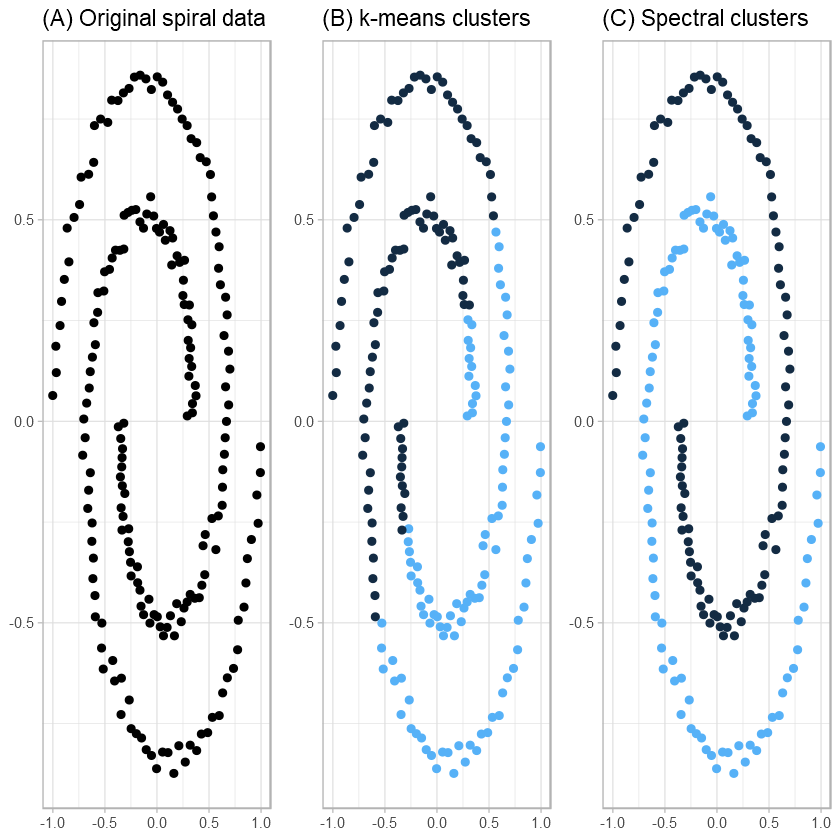

In [44]:
p1 <- ggplot(df, aes(x, y)) +
  geom_point() +
  xlab(NULL) +
  ylab(NULL) +
  ggtitle('(A) Original spiral data')

kmeans_on_spiral <- kmeans(df[, 1:2], 2)
df$kmeans_clusters <- kmeans_on_spiral$cluster
p2 <- ggplot(df, aes(x, y, color = kmeans_clusters)) +
  geom_point(show.legend = FALSE) +
  xlab(NULL) +
  ylab(NULL) +
  ggtitle('(B) k-means clusters')

sc <- kernlab::specc(as.matrix(df[, 1:2]), centers = 2)
df$spec_clusters <- sc@.Data
p3 <- ggplot(df, aes(x, y, color = spec_clusters)) +
  geom_point(show.legend = FALSE) +
  xlab(NULL) +
  ylab(NULL) +
  ggtitle('(C) Spectral clusters')

gridExtra::grid.arrange(p1, p2, p3, nrow = 1)

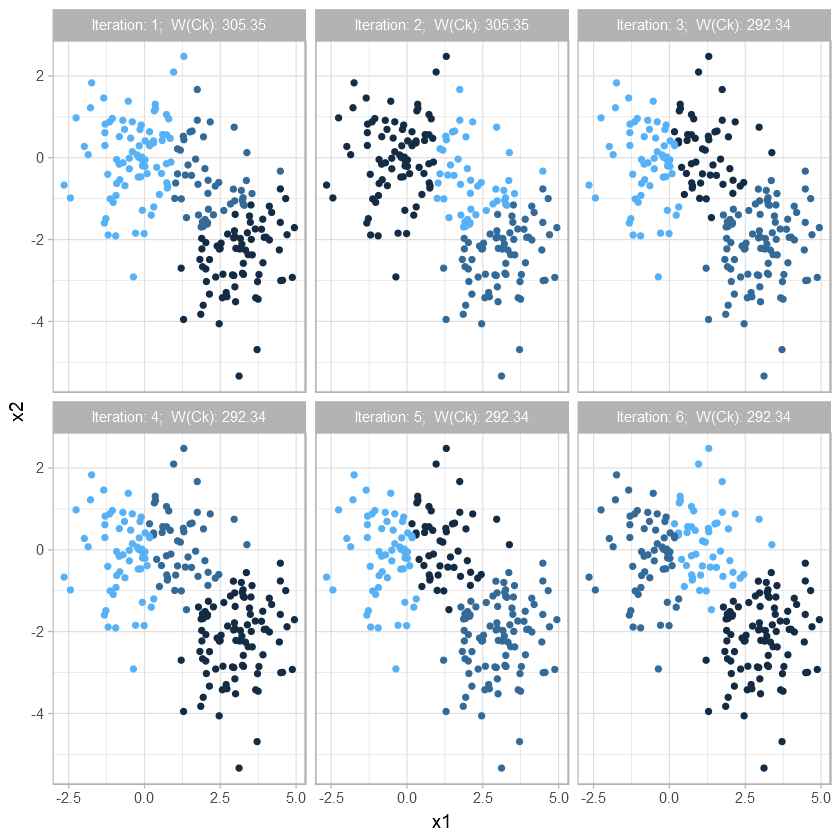

In [74]:
df <- data_frame(
    x1 = c(rnorm(100), rnorm(100) + 3),
    x2 = c(rnorm(100), rnorm(100) - 2)
)

map(1:6, ~ kmeans(df, 3)) %>%
  map2_dfr(1:6, ~ df %>% mutate(
    cluster = .x$cluster,
    name = paste0("Iteration: ", .y, ";  W(Ck): ", round(.x$tot.withinss, 2))
    )) %>%
  ggplot(aes(x1, x2, colour = cluster)) +
  geom_point(show.legend = FALSE, size = 1) +
  facet_wrap(~ name, nrow = 2)

#### mnist

In [26]:
features <- mnist$train$images

mnist_clustering <- kmeans(features, centers = 10, nstart = 10)

Warning message:
"did not converge in 10 iterations"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 3000000)"
Warning message:
"did not converge in 10 iterations"


In [76]:
str(mnist_clustering)

List of 9
 $ cluster     : int [1:60000] 2 9 4 1 7 3 8 2 8 7 ...
 $ centers     : num [1:10, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:10] "1" "2" "3" "4" ...
  .. ..$ : NULL
 $ totss       : num 2.06e+11
 $ withinss    : num [1:10] 1.04e+10 1.81e+10 1.51e+10 2.41e+10 1.58e+10 ...
 $ tot.withinss: num 1.53e+11
 $ betweenss   : num 5.27e+10
 $ size        : int [1:10] 5620 6544 4681 8918 5717 7447 8837 5967 3176 3093
 $ iter        : int 10
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


#### 각 군집의 중심 확인

In [77]:
(mnist_centers <- mnist_clustering$centers)

1,0,0,0,0,0,0,0,0,0,0,...,0.0341637,0.0003558719,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1.3269791,0.5976676385,0.3070195,0.12256111,0.09452792,0.01345593,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0.0000000,0.0000000000,0.0000000,0.02069188,0.02069188,0.00000000,0,0,0,0


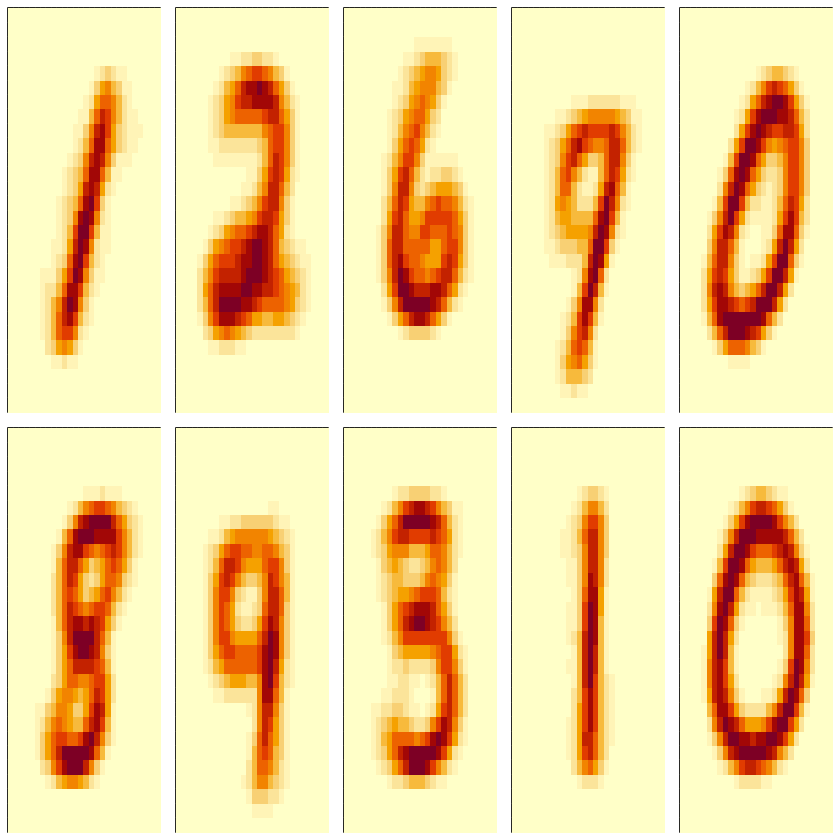

In [78]:
par(mfrow = c(2, 5), mar = c(0.5, 0.5, 0.5, 0.5))
layout(matrix(seq_len(nrow(mnist_centers)), 2, 5, byrow = F))
for (i in seq_len(nrow(mnist_centers))) {
    image(matrix(mnist_centers[i, ], 28, 28)[, 28:1],
         xaxt = "n", yaxt = "n")
}

### 혼동행렬

In [94]:
mode_fun <- function(x){  
  which.max(tabulate(x))
}

mnist_comparison <- data.frame(
  cluster = mnist_clustering$cluster,
  actual = mnist$train$labels
) %>%
  group_by(cluster) %>%
  mutate(mode = mode_fun(actual)) %>%
  ungroup() %>%
  mutate_all(factor, levels = 0:9)

mnist_comparison %>% head() ; dim(mnist_comparison)

cluster,actual,mode
<fct>,<fct>,<fct>
2,5,8
9,0,5
4,4,4
1,1,1
7,9,7
3,2,2


[1] 60000     3

- cluster : 관측값이 속한 군집
- actual : 관측값의 실제 값
- mode : 관측값이 속한 군집의 최빈값

### ```yardstick::confmat()```
- ```data``` 
- ```truth``` : 실제값
- ```estimate``` : 예측값

          Truth
Prediction    0    1    2    3    4    5    6    7    8    9
         0    0    0    0    0    0    0    0    0    0    0
         1   24 6695  718  530  472  967  496  610  717  358
         2   17    9 4195  216   38   14   85   39   55   13
         3  162    5  327 3924    1 1773   28    5 1137   85
         4   38    6  172  176 3187  374   82 1791  192 2900
         5 2503    0   97  126   11  252  122   14   32   19
         6 2983    8  222   74  174  188 5012   19   85   45
         7   14    9   69   48 1938  342    1 3777  179 2460
         8  182   10  158 1037   21 1511   92   10 3454   69
         9    0    0    0    0    0    0    0    0    0    0

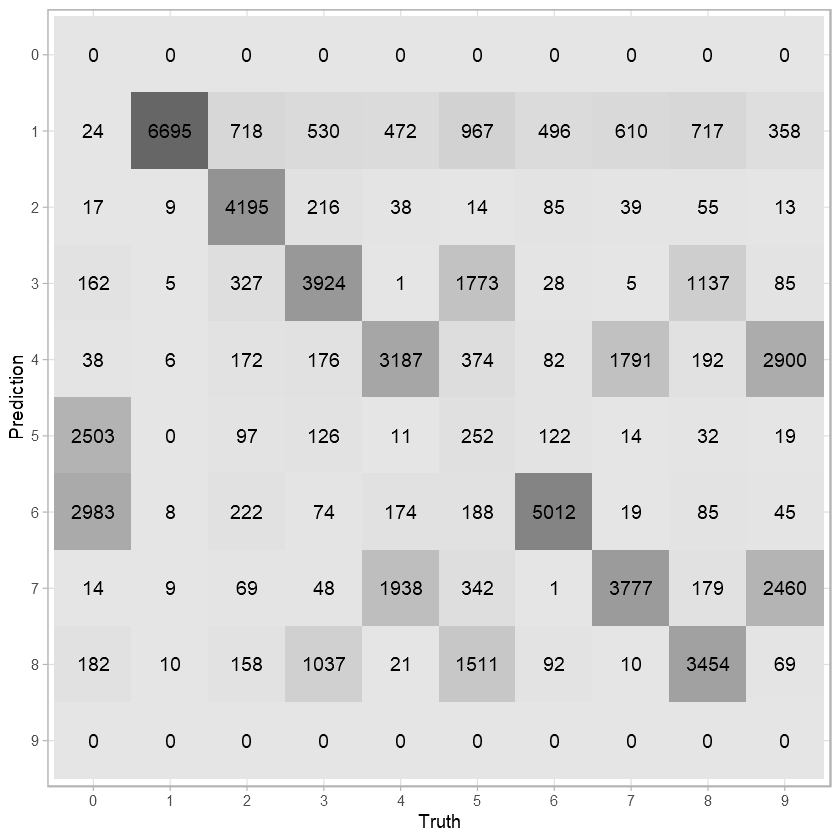

In [98]:
cm <- yardstick::conf_mat(
  mnist_comparison, 
  truth = actual, 
  estimate = mode
) 
cm ; cm %>% autoplot("heatmap")

### 군집의 수
- k가 클수록 균질성을 향상시킬 수 있습니다. 그러나 과적합의 위험이
- 주어진 사전적인 라벨값이 있다면, 라벨값을 k로 사용
- 사전적인 정보가 없다면 k = sqrt(n/2)

#### 엘보우 기법
- 군집내 총 제곱합(WSS)은 군집의 간결함의 정도, 가능한 최소화
1. k별 WSS계산
2. WSS값의 곡선을 plot
3. plot의 엘보우 포인트를 적절한 k로 선정

### ```fviz_nbclust()```
- 클러스터 내 제곱합, 평균 실루엣 및 간격 통계와 같은 다양한 방법을 사용하여 최적의 클러스터 수를 결정하고 시각화
- ```method``` : 사용할 척도 ["silhouette", "wss", "gap_stat"]
- ```k.max``` : 적용할 k의 최대범위
- ```diss``` : ```dist()```에 의해 생성된 객체 (거리행렬) 

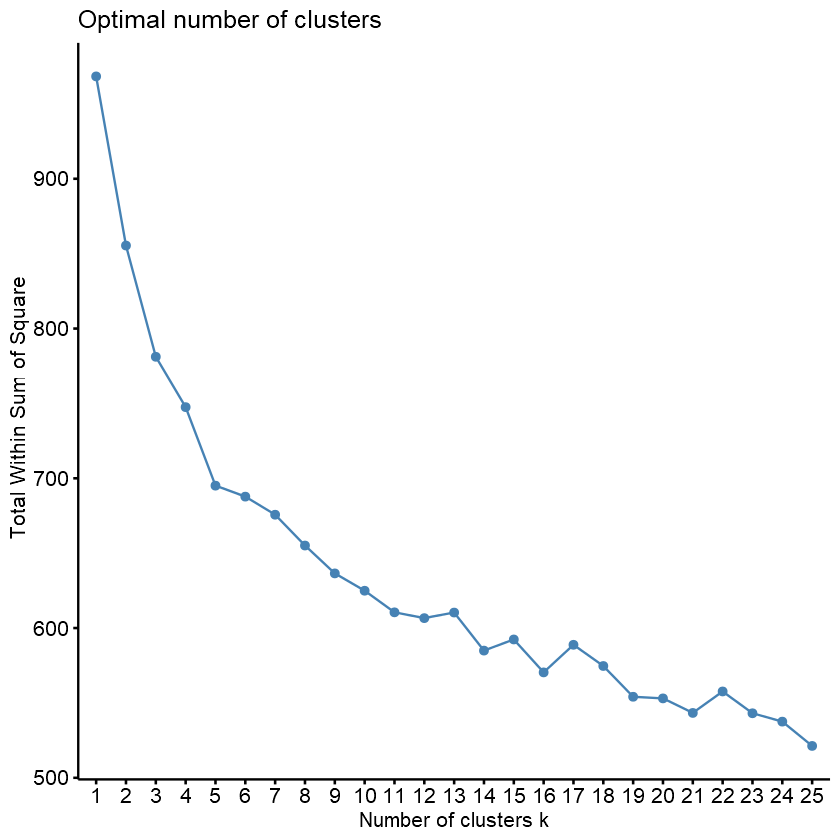

In [103]:
fviz_nbclust(
  my_basket, 
  kmeans, 
  k.max = 25,
  method = "wss",
  diss = get_dist(my_basket, method = "spearman") # 스피어만 상관관계 기반 거리
)

#### 엘보우 포인트 = 5

### 범주형 및 순서형변수가 포함된 데이터 군집화
#### - 모든 범주형 및 순서형 변수를 수치형으로 변경 (원-핫 인코딩)

순서형 변수들을 수치형으로 변경

In [141]:
ames_full <- AmesHousing::make_ames()

In [117]:
ames_full[str_detect(names(ames_full), 'Qual|Cond|QC|Qu')] %>% head

Condition_1,Condition_2,Overall_Qual,Overall_Cond,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Heating_QC,Low_Qual_Fin_SF,Kitchen_Qual,Fireplace_Qu,Garage_Qual,Garage_Cond,Pool_QC,Sale_Condition
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
Norm,Norm,Above_Average,Average,Typical,Typical,Typical,Good,Fair,0,Typical,Good,Typical,Typical,No_Pool,Normal
Feedr,Norm,Average,Above_Average,Typical,Typical,Typical,Typical,Typical,0,Typical,No_Fireplace,Typical,Typical,No_Pool,Normal
Norm,Norm,Above_Average,Above_Average,Typical,Typical,Typical,Typical,Typical,0,Good,No_Fireplace,Typical,Typical,No_Pool,Normal
Norm,Norm,Good,Average,Good,Typical,Typical,Typical,Excellent,0,Excellent,Typical,Typical,Typical,No_Pool,Normal
Norm,Norm,Average,Average,Typical,Typical,Good,Typical,Good,0,Typical,Typical,Typical,Typical,No_Pool,Normal
Norm,Norm,Above_Average,Above_Average,Typical,Typical,Typical,Typical,Excellent,0,Good,Good,Typical,Typical,No_Pool,Normal


In [133]:
ames_full <- AmesHousing::make_ames() %>%
  mutate_if(str_detect(names(.), 'Qual|Cond|QC|Qu'), as.numeric)
ames_full[str_detect(names(ames_full), 'Qual|Cond|QC|Qu')] %>% head

Condition_1,Condition_2,Overall_Qual,Overall_Cond,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Heating_QC,Low_Qual_Fin_SF,Kitchen_Qual,Fireplace_Qu,Garage_Qual,Garage_Cond,Pool_QC,Sale_Condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,3,6,5,4,5,6,3,2,0,5,3,6,6,4,5
2,3,5,6,4,5,6,6,5,0,5,4,6,6,4,5
3,3,6,6,4,5,6,6,5,0,3,4,6,6,4,5
3,3,7,5,3,5,6,6,1,0,1,6,6,6,4,5
3,3,5,5,4,5,3,6,3,0,5,6,6,6,4,5
3,3,6,6,4,5,6,6,1,0,3,3,6,6,4,5


명목형 변수들을 원-핫 인코딩

### ```caret::dummyVars()```

In [134]:
full_rank  <- caret::dummyVars(Sale_Price ~ ., data = ames_full, 
                               fullRank = TRUE)
ames_1hot <- predict(full_rank, ames_full)

In [135]:
ames_1hot %>% head

,MS_SubClass.One_Story_1945_and_Older,MS_SubClass.One_Story_with_Finished_Attic_All_Ages,MS_SubClass.One_and_Half_Story_Unfinished_All_Ages,MS_SubClass.One_and_Half_Story_Finished_All_Ages,MS_SubClass.Two_Story_1946_and_Newer,MS_SubClass.Two_Story_1945_and_Older,MS_SubClass.Two_and_Half_Story_All_Ages,MS_SubClass.Split_or_Multilevel,MS_SubClass.Split_Foyer,MS_SubClass.Duplex_All_Styles_and_Ages,...,Sale_Type.ConLI,Sale_Type.ConLw,Sale_Type.CWD,Sale_Type.New,Sale_Type.Oth,Sale_Type.VWD,Sale_Type.WD,Sale_Condition,Longitude,Latitude
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-93.61975,42.05403
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-93.61976,42.05301
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-93.61939,42.05266
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-93.61732,42.05125
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-93.63893,42.06090
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-93.63893,42.06078


### ```scale()```
- 데이터 정규화
- ```center``` : TRUE면 모든 데이터에서 전체 데이터의 평균을 뺀다.
- ```scale``` : TRUE일 때 center도 TRUE면 모든 데이터를 전체 데이터의 표준 편차로 나눈다. scale이 TRUE지만 center는 FALSE면 모든 데이터를 전체 데이터의 제곱 평균 제곱근으로 나눈다. scale이 FALSE면 데이터를 어떤 값으로도 나누지 않는다.

In [136]:
head(ames_1hot_scaled <- scale(ames_1hot, center = T, scale = T))

,MS_SubClass.One_Story_1945_and_Older,MS_SubClass.One_Story_with_Finished_Attic_All_Ages,MS_SubClass.One_and_Half_Story_Unfinished_All_Ages,MS_SubClass.One_and_Half_Story_Finished_All_Ages,MS_SubClass.Two_Story_1946_and_Newer,MS_SubClass.Two_Story_1945_and_Older,MS_SubClass.Two_and_Half_Story_All_Ages,MS_SubClass.Split_or_Multilevel,MS_SubClass.Split_Foyer,MS_SubClass.Duplex_All_Styles_and_Ages,...,Sale_Type.ConLI,Sale_Type.ConLw,Sale_Type.CWD,Sale_Type.New,Sale_Type.Oth,Sale_Type.VWD,Sale_Type.WD,Sale_Condition,Longitude,Latitude
1,-0.2231276,-0.04529109,-0.07860794,-0.3294718,-0.4940425,-0.2136962,-0.08893389,-0.2048138,-0.1290326,-0.1965339,...,-0.05549851,-0.05231555,-0.0641171,-0.2979669,-0.04892834,-0.01847422,0.3940936,0.204531,0.9005169,1.0620690
2,-0.2231276,-0.04529109,-0.07860794,-0.3294718,-0.4940425,-0.2136962,-0.08893389,-0.2048138,-0.1290326,-0.1965339,...,-0.05549851,-0.05231555,-0.0641171,-0.2979669,-0.04892834,-0.01847422,0.3940936,0.204531,0.9004391,1.0066102
3,-0.2231276,-0.04529109,-0.07860794,-0.3294718,-0.4940425,-0.2136962,-0.08893389,-0.2048138,-0.1290326,-0.1965339,...,-0.05549851,-0.05231555,-0.0641171,-0.2979669,-0.04892834,-0.01847422,0.3940936,0.204531,0.9147856,0.9873273
4,-0.2231276,-0.04529109,-0.07860794,-0.3294718,-0.4940425,-0.2136962,-0.08893389,-0.2048138,-0.1290326,-0.1965339,...,-0.05549851,-0.05231555,-0.0641171,-0.2979669,-0.04892834,-0.01847422,0.3940936,0.204531,0.9952267,0.9105215
5,-0.2231276,-0.04529109,-0.07860794,-0.3294718,2.0234264,-0.2136962,-0.08893389,-0.2048138,-0.1290326,-0.1965339,...,-0.05549851,-0.05231555,-0.0641171,-0.2979669,-0.04892834,-0.01847422,0.3940936,0.204531,0.1542399,1.4349084
6,-0.2231276,-0.04529109,-0.07860794,-0.3294718,2.0234264,-0.2136962,-0.08893389,-0.2048138,-0.1290326,-0.1965339,...,-0.05549851,-0.05231555,-0.0641171,-0.2979669,-0.04892834,-0.01847422,0.3940936,0.204531,0.1545512,1.4283902


In [138]:
dim(ames_1hot_scaled)

[1] 2930  241

In [ ]:
set.seed(123)

fviz_nbclust(
  ames_1hot_scaled, 
  kmeans, 
  method = "wss", 
  k.max = 25, 
  verbose = FALSE
)

<img src = "https://bradleyboehmke.github.io/HOML/18-kmeans_files/figure-html/kmeans-silhouette-mixed-1.png">

### 변수의 수가 증가함에 따라 k-means의 성능이 저하 
- 적절한 엘보우 포인트 탐색 불가 => **Gower 거리 측정**

### Gower 거리
- 정량적 (간격) 데이터 : 정규화 맨해튼 거리
- 순서형 데이터 : 변수가 먼저 순위가 매겨진 다음, 맨하탄 거리가 동률에 대한 특별 조정과 함께 사용
- 명목형 데이터 : k개의 범주를 가진 범주형 변수는, k개의 열을 가진 데이터로 변환(원-핫 인코딩), 주사위 계수 (Dice coefficient)가 사용됨, 
- 주사위 계수 : 두 관측치(X, Y)에 대해 (모두 원-핫 인코딩된 범주형 데이터)
    * a = X와 Y가 모두 1인 dummy 수
    * b = X가 1, Y가 0인 dummy 수
    * c = X가 0, Y가 1인 dummy 수
    * d = X와 Y가 모두 0인 dummy 수
- D = 2a / (2a + b + c)

### ```cluster::daisy()```
- 데이터 세트의 관측치 사이의 모든 쌍별 비유사도(거리)를 계산
- ```metric``` : "gower"로 지정함으로써 Gower 거리 계산 ["euclidean", "manhattan", "gower"}

In [152]:
?cluster::daisy

In [143]:
ames_full <- AmesHousing::make_ames() %>% select(-Sale_Price)
gower_dst <- cluster::daisy(ames_full, metric = "gower")

#### Gower 거리 행렬은 ```cluster::diana()```, ```cluster::agnes()```, ```cluster::pam()```에만 사용 가능
- ```cluster::kmeans()```, ```cluster::clara()```에는 적용 불가

In [145]:
pam_gower <- pam(x = gower_dst, k = 8, diss = TRUE)
diana_gower <- diana(x = gower_dst, diss = TRUE)
agnes_gower <- agnes(x = gower_dst, diss = TRUE)

### 대체 분할 방법 (PAM)
- 데이터의 차원이 증가함에 따라 더 많은 이상치 발생 가능
- k -means는 평균을 사용하므로 이상치에 취약
- 이의 대안으로 PAM(partitioning around medians)을 사용
- 이상치에 더 robust하게 만듬

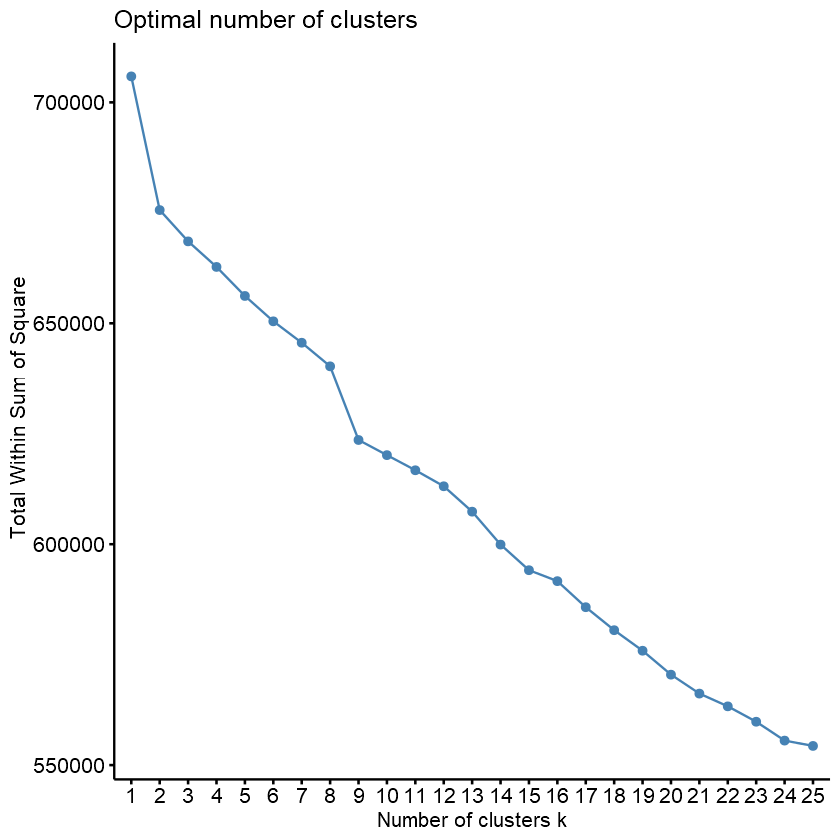

In [153]:
fviz_nbclust(
  ames_1hot_scaled, 
  pam, 
  method = "wss", 
  k.max = 25, 
  verbose = FALSE
)

### clustering large applications (CLARA)
- 데이터 세트가 계층적으로 커지면 k-means와 PAM 군집화가 느려짐
- 이의 대안으로 CLARA사용, 전체 데이터에 대해 중심점(medoid)를 탐색하는 대신 작은 크기에 대해 kmeans나 PAM을 적용
1. 데이터 세트를 고정 크기의 여러 하위집합으로 무작위로 분할.
2. 각 부분 집합에 대해 PAM 알고리즘을 계산하고, k-medoid에 해당하는 항목을 선택. 전체 데이터 세트의 각 관측값을 가장 가까운 medoid에 할당합니다.
3. 가장 가까운 medoid에 대한 관측치의 비유사성의 평균(또는 합)을 계산. 이것은 군집적합도의 척도로 사용.
4. 평균(또는 합계)이 최소인 하위 데이터 세트를 유지.

In [154]:
system.time(kmeans(features, centers = 10))
system.time(clara(features, k = 10))

   user  system elapsed 
  42.31    2.44   49.03 

   user  system elapsed 
  66.75    1.19   71.61 

In [155]:
mnist_clara <- clara(features, k = 10)

In [156]:
str(mnist_clara)

List of 10
 $ sample    : int [1:60] 392 1807 2418 3722 4448 7633 8003 8892 8993 10135 ...
 $ medoids   : int [1:10, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
 $ i.med     : int [1:10] 45432 35517 20485 38910 41762 7633 25539 41923 34571 30250
 $ clustering: int [1:60000] 1 2 3 4 5 1 6 1 6 1 ...
 $ objective : num 2010
 $ clusinfo  : num [1:10, 1:4] 10427 3675 3704 9454 6349 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "size" "max_diss" "av_diss" "isolation"
 $ diss      : 'dissimilarity' num [1:1770] 2910 2734 3090 2482 2770 ...
  ..- attr(*, "Size")= int 60
  ..- attr(*, "Metric")= chr "euclidean"
 $ call      : language clara(x = features, k = 10)
 $ silinfo   :List of 3
  ..$ widths         : num [1:60, 1:3] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:60] "2418" "392" "43376" "38258" ...
  .. .. ..$ : chr [1:3] "cluster" "neighbor" "sil_width"
  ..$ clus.avg.widths: num [1:10] -0.0404 0.2354 0.0888 0.1078 0.0873 ...
  ..$

In [161]:
(mnist_medoids <- mnist_clara$medoids)

0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


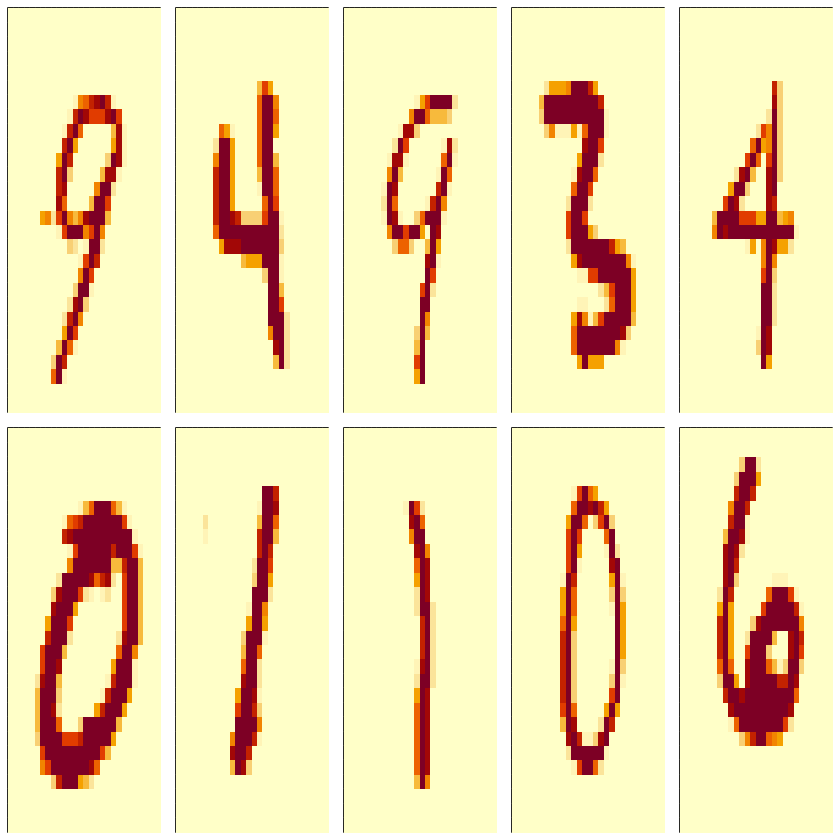

In [162]:
par(mfrow = c(2, 5), mar = c(0.5, 0.5, 0.5, 0.5))
layout(matrix(seq_len(nrow(mnist_medoids)), 2, 5, byrow = F))
for (i in seq_len(nrow(mnist_medoids))) {
    image(matrix(mnist_medoids[i, ], 28, 28)[, 28:1],
         xaxt = "n", yaxt = "n")
}